> May 06, 2024 | {sub-ref}`wordcount-minutes` min read




(sec_La_Molécula_de_H2)= 
# La molécula de $\text{H}_2$

In [1]:
# Librerías generales
import numpy as np
from collections import defaultdict
from functools import reduce
from itertools import product
import random
import scipy
import matplotlib.pyplot as plt

# Librerías Qibo
import qibo
from qibo import models, gates, hamiltonians
from qibo import matrices as m

# Librerías Qiskit
import qiskit
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit.library import TwoLocal
from qiskit.tools.parallel import parallel_map

random.seed()

qibo.set_backend("numpy")

%matplotlib inline

/tmp/ipykernel_56655/2196755265.py:19: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, POWELL
[Qibo 0.1.12.dev0|INFO|2024-04-18 11:14:55]: Using numpy backend on /CPU:0


El algoritmo VQE se propuso originalmente para obtener el estado de mínima energía de moléculas complicadas a partir de su Hamiltoniano {cite}`bib_peruzzo_variational_2014`. Por este motivo, gran parte de su historia y sus aplicaciones se han desarrollado y estudiado dentro del ámbito de la química computacional. También por este motivo, muchas librerías y lenguajes de programación orientados a utilizar computadores cuánticos tienen integradas multitud de funciones y características para trabajar con moléculas.


Por ejemplo, Google tiene su librería de computación cuántica [```openfermion```](https://quantumai.google/openfermion), mientras que Qiskit tiene, en su módulo ```qiskit_nature```, un método para construir moléculas utilizando PYSCF.

:::::{tab-set}
::::{tab-item} Qibo
```python

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion import jordan_wigner, count_qubits

# NOTA: Haciendo este código me ha salido un error interno de las librerías de pyscf.
# Este error alega que no existe un módulo llamado openfermion.chem
# Esto puede deberse a que la versión de openfermion esté en una versión no compatible.
# Para solucionarlo, basta con ir al script de la función de pyscf y cambiar el comando
# from openfermion.chem import *
#   por
# from openfermion import *
```
::::
::::{tab-item} Qiskit
```python

import qiskit_nature
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitMapper
```
::::
:::::


In [2]:
'''Qibo_code_cell'''

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion import jordan_wigner, count_qubits

# NOTA: Haciendo este código me ha salido un error interno de las librerías de pyscf.
# Este error alega que no existe un módulo llamado openfermion.chem
# Esto puede deberse a que la versión de openfermion esté en una versión no compatible.
# Para solucionarlo, basta con ir al script de la función de pyscf y cambiar el comando
# from openfermion.chem import *
#   por
# from openfermion import *

Este módulo nos permite, entre otras cosas, fabricar diferentes moléculas, especificando los diferentes átomos que la componen, la base de funciones de la función de onda del electrón, la carga y la multiplicidad de la molécula.

De todas las posibles moléculas que podríamos tratar, la más sencilla es la de $\text{H}_2$: el átomo de Hidrógeno es el más pequeño y simple, presenta un único enlace y solo tiene dos electrones.


Aun así, al contrario que el Modelo de Ising, la molécula de Hidrógeno presenta un problema: no es resoluble analíticamente. En su lugar, el "valor teórico" de su energía fundamental es realmente el resultado de simulaciones y experimentos, en ocasiones dando resultados en forma de operaciones infinitas que hay que truncar en alguna parte. 


Así, por ejemplo, en {cite}`bib_pang_hydrogen_1994` se presenta un resultado de $-1.1746(5) E_h$ a partir de simulaciones de Monte Carlo, mientras que en {cite}`bib_yang_calculating_2019` obtienen un resultado comprendido entre $-1.2241 E_h$ y $-1.0999 E_h$ empleando el modelo de Bohr.

:::::{tab-set}
::::{tab-item} Qibo
```python

# Creamos la molécula con los parámetros requeridos

# Parámetros moleculares
bond_length = 1.40104295
multiplicity = 1    # Dependiendo del tipo de molécula, el spin queda determinado por la multiplicidad. Si lo detecta como incompatible, dará error.
basis = 'sto-3g'
charge = 0

# Especificamos los elementos y su disposición geométrica
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]

# Parámetros del cálculo. En nuestro caso especificamos solo run_scf porque nos basta con haber hecho solo Hartree-Fock.
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
delete_input = True
delete_output = True

# Inicializamos la estructura molecular
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description=str(bond_length))

# Calculamos sus integrales
molecule = run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)


```
::::
::::{tab-item} Qiskit
```python

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.741",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
    # El método de aproximación por defecto es Hartree-Fock: method=MethodType.RHF
)

es_problem = driver.run()
```
::::
:::::


In [3]:
'''Qibo_code_cell'''

# Creamos la molécula con los parámetros requeridos

# Parámetros moleculares
bond_length = 1.40104295
multiplicity = 1    # Dependiendo del tipo de molécula, el spin queda determinado por la multiplicidad. Si lo detecta como incompatible, dará error.
basis = 'sto-3g'
charge = 0

# Especificamos los elementos y su disposición geométrica
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]

# Parámetros del cálculo. En nuestro caso especificamos solo run_scf porque nos basta con haber hecho solo Hartree-Fock.
run_scf = 1
run_mp2 = 0
run_cisd = 0
run_ccsd = 0
run_fci = 0
delete_input = True
delete_output = True

# Inicializamos la estructura molecular
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description=str(bond_length))

# Calculamos sus integrales
molecule = run_pyscf(molecule,
                        run_scf=run_scf,
                        run_mp2=run_mp2,
                        run_cisd=run_cisd,
                        run_ccsd=run_ccsd,
                        run_fci=run_fci)



Mientras que Qiskit puede generar el Hamiltoniano de la molécula con sus propias funciones, con Qibo necesitamos fabricar una función que nos convierta el problema molecular en uno legible por un circuito cuántico.

:::::{tab-set}
::::{tab-item} Qibo
```python

def qibo_mol_H(molecule):

    # molecule es una estructura molecular de OpenFermion
    # devuelve un Hamiltoniano en términos de Qibo

    # Obtenemos el Hamiltoniano molecular de nuestra molécula fabricada con OpenFermion
    H = molecule.get_molecular_hamiltonian()

    # Nos aseguramos de que el término constante está bien definido
    if H.constant is None: H.constant = 0

    # Hacemos la transformación de Jordan Wigner
    JW = jordan_wigner(H)
    dim = count_qubits(JW)

    # Inicializamos el operador con el término constante
    operator = JW.constant * reduce(np.kron, [m.I]*dim)  

    # Recorremos los términos del operador de Jordan-Wigner
    for index in JW.terms.keys():
        if index == ():
            continue # Omitimos el término constante, ya que hemos inicializado con él

        # Definimos una lista auxiliar de operadores identidad del tamaño del sistema
        lis = [m.I]*dim

        # Reemplazamos en nuestra lista los operadores en la posición en la que indica el término de JW
        for tag in index:
            if tag[1] == 'X': lis[tag[0]] = m.X
            elif tag[1] == 'Y': lis[tag[0]] = m.Y
            elif tag[1] == 'Z': lis[tag[0]] = m.Z

        # Sumamos el término JW a nuestro operador matricial
        operator += JW.terms[index] * reduce(np.kron, lis)

    return hamiltonians.Hamiltonian(dim, operator), dim, operator
```
::::
::::{tab-item} Qiskit
```python

converter = JordanWignerMapper()
```
::::
:::::


In [4]:
'''Qibo_code_cell'''

def qibo_mol_H(molecule):

    # molecule es una estructura molecular de OpenFermion
    # devuelve un Hamiltoniano en términos de Qibo

    # Obtenemos el Hamiltoniano molecular de nuestra molécula fabricada con OpenFermion
    H = molecule.get_molecular_hamiltonian()

    # Nos aseguramos de que el término constante está bien definido
    if H.constant is None: H.constant = 0

    # Hacemos la transformación de Jordan Wigner
    JW = jordan_wigner(H)
    dim = count_qubits(JW)

    # Inicializamos el operador con el término constante
    operator = JW.constant * reduce(np.kron, [m.I]*dim)  

    # Recorremos los términos del operador de Jordan-Wigner
    for index in JW.terms.keys():
        if index == ():
            continue # Omitimos el término constante, ya que hemos inicializado con él

        # Definimos una lista auxiliar de operadores identidad del tamaño del sistema
        lis = [m.I]*dim

        # Reemplazamos en nuestra lista los operadores en la posición en la que indica el término de JW
        for tag in index:
            if tag[1] == 'X': lis[tag[0]] = m.X
            elif tag[1] == 'Y': lis[tag[0]] = m.Y
            elif tag[1] == 'Z': lis[tag[0]] = m.Z

        # Sumamos el término JW a nuestro operador matricial
        operator += JW.terms[index] * reduce(np.kron, lis)

    return hamiltonians.Hamiltonian(dim, operator), dim, operator

Y, una vez tenemos el Hamiltoniano, podemos implementar el algoritmo VQE igual que hicimos antes:

:::::{tab-set}
::::{tab-item} Qibo
```python

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

op_H, n, mat = qibo_mol_H(molecule)

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
```
::::
::::{tab-item} Qiskit
```python

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)
```
::::
:::::


In [5]:
'''Qibo_code_cell'''

# Ahora creamos un circuito variacional de ansatz
# En este caso usamos un circuito de puertas RY(theta) y CZ, haciendo los diferentes valores de theta aleatorios

op_H, n, mat = qibo_mol_H(molecule)

nqubits = n
nlayers  = 8

circuit = models.Circuit(nqubits)

for l in range(nlayers):
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(0, nqubits-1, 2)))
    circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))
    circuit.add((gates.CZ(q, q+1) for q in range(1, nqubits-2, 2)))
    circuit.add(gates.CZ(0, nqubits-1))
    
circuit.add((gates.RY(q, theta=0) for q in range(nqubits)))

Utilizamos, de nuevo, el algoritmo de optimización de Powell.

::::::{admonition} Nota (Eficiencia en la optimización) 
:class: note


    
El algoritmo de Powell que estamos empleando es considerablemente más eficiente que el resto de algoritmos que hemos probado para este problema específicamente. No obstante, su funcionamiento da lugar a unas gráficas de convergencia que no son particularmente ilustrativas. Si se quiere ver una gráfica en la que realmente se aprecie la convergencia del algoritmo, se puede probar a utilizar el algoritmo COBYLA. No obstante, la ejecución del código tardará un tiempo considerable (del orden de 20 minutos).

::::::


:::::{tab-set}
::::{tab-item} Qibo
```python

# Optimizador
# opt = 'COBYLA'
opt = 'Powell'
```
::::
::::{tab-item} Qiskit
```python

# Optimizador
# opt = COBYLA(maxiter=1000)
opt = POWELL()
```
::::
:::::


In [6]:
'''Qibo_code_cell'''

# Optimizador
# opt = 'COBYLA'
opt = 'Powell'

De nuevo necesitamos funciones de callback

:::::{tab-set}
::::{tab-item} Qibo
```python

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)
    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    
    intermediate_info['energy'].append(energy)
    
    #intermediate_info['stddev'].append(stddev)
```
::::
::::{tab-item} Qiskit
```python

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(eval_count, parameters, mean, std):
   intermediate_info['parameters'].append(parameters)
   intermediate_info['energy'].append(mean)
```
::::
:::::


In [7]:
'''Qibo_code_cell'''

# Esto son funciones auxiliares para guardar los datos de las iteraciones

intermediate_info = {
    'parameters': [],
    'energy': [],
    #'stddev': []
}

def callback(p):
    intermediate_info['parameters'].append(p)
    
    energy, _, _ = vqe.minimize(p, callback = None, method=opt, options = None, compile=False)
    
    intermediate_info['energy'].append(energy)
    
    #intermediate_info['stddev'].append(stddev)

:::::{tab-set}
::::{tab-item} Qibo
```python

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)
```
::::
::::{tab-item} Qiskit
```python

# Y ejecutamos el algoritmo
vqe_solver = VQE(Estimator(), tl_circuit, opt, callback=callback)

calc = GroundStateEigensolver(converter, vqe_solver)

res = calc.solve(es_problem)
best = res.total_energies
```
::::
:::::


In [8]:
'''Qibo_code_cell'''

# Parámetros del Ansatz
initial_parameters = np.random.uniform(-2*np.pi, 2*np.pi, 2*nqubits*nlayers + nqubits)

# Construcción del método VQE
vqe = models.VQE(circuit, op_H)
options = {'disp': True, 'return_all': True}

# Y ejecutamos el algoritmo
best, params, extra = vqe.minimize(initial_parameters, callback = callback, method=opt, options = options, compile=False)

Optimization terminated successfully.
         Current function value: -1.015272
         Iterations: 6
         Function evaluations: 3698


In [9]:
# Vemos el valor al que convergemos
print('E_G =',best)

E_G = -1.0152716812248899


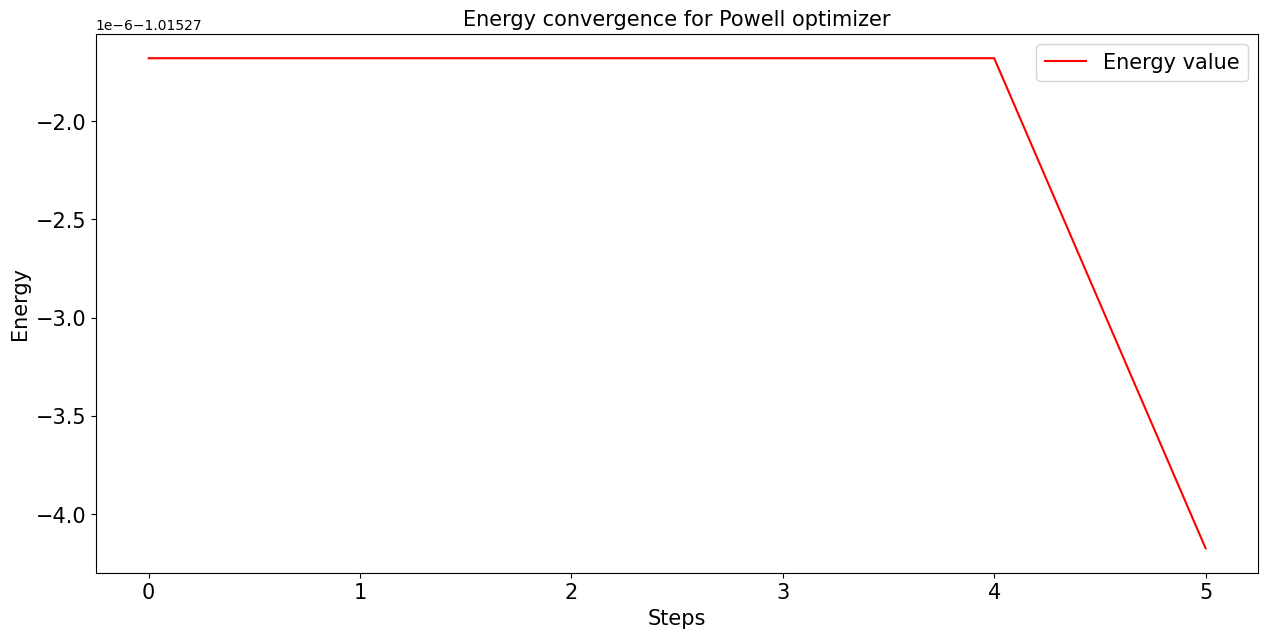

In [10]:
# Con la información de las iteraciones podemos dibujar la convergencia de nuestro código

sim_values = intermediate_info['energy']
fontsize = 15

plt.rcParams['figure.figsize'] = (15, 7)
plt.plot(range(len(sim_values)), sim_values, label="Energy value", color='red')
plt.xticks(fontsize = fontsize)
plt.yticks(fontsize = fontsize)
plt.xlabel('Steps', fontsize = fontsize)
plt.ylabel('Energy', fontsize = fontsize)
plt.title('Energy convergence for Powell optimizer', fontsize = fontsize)
plt.legend(loc='upper right', fontsize = fontsize);
plt.show()

Para este caso concreto es importante destacar que el problema que hemos resuelto es la diagonalización del Hamiltoniano de Hartree-Fock de la molécula.


Existen otros modelos de *ansatz* (como los *ansätze* UCC) que, antes que hacer la diagonalización, operan sobre el circuito introduciendo términos y consideraciones nuevas, como correcciones relativistas o correlación electrónica, y después obtienen la energía fundamental, de forma que la resolución del problema tiene en cuenta efectos más difíciles de simular con computadores clásicos.

---
## Bibliografía 
```{bibliography} 
:style: plain
:filter: docname in docnames
```

---
Authors:

Irais Bautista ([CESGA](http://www.cesga.es)), Sergio Martínez ([BIFi-UNIZAR](https://bifi.es/es/)), Jaime Scharfhausen ([UAM](https://www.uam.es/uam/inicio)) y Alejandro Jaramillo ([CSUC](https://www.csuc.cat/es))

<img src="https://quantumspain-project.es/wp-content/uploads/2022/11/CESGA.png" width="150px">
<img src="http://bifi.es/wp-content/uploads/2016/11/logo_vectorial-web.png" width="200px">
<img src="https://www.iib.uam.es/iiblf6theme-theme/images/custom/logo-uam.png" width = "200px">
<img src="https://www.csuc.cat/sites/default/files/2021-02/CSUC_logo_corporatiu_0.png" width = "200px">


---
::::{figure} https://quantumspain-project.es/wp-content/uploads/2022/11/Logo_QS_EspanaDigital.png
:width: 2000px
:align: center
::::

<center>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">
<img aling="left" alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
</center>

License: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Licencia Creative Commons Atribución-CompartirIgual 4.0 Internacional</a>.

This work has been financially supported by the Ministry for Digital Transformation and of Civil Service of the Spanish Government through the QUANTUM ENIA project call - Quantum Spain project, and by the European Union through the Recovery, Transformation and Resilience Plan - NextGenerationEU within the framework of the Digital Spain 2026 Agenda.

<center>
<img align="left" src="https://quantumspain-project.es/wp-content/uploads/2024/02/Banner-QS_GOB_v2.png" width="1000px" />
</center>